In [1]:
import sys
import os
sys.path.append("../src/whole_history_rating")
from whr import whole_history_rating
from whr import utils
from datetime import datetime
import datetime as dt
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from scipy.optimize import curve_fit

In [2]:
data_path = '../data/cfbd/games_1990_to_2020.csv'

In [3]:
games_df = pd.read_csv(data_path)
games_df_test = games_df[games_df.season<2015]
games_df_verify = games_df[games_df.season>=2015]
games_df.shape

(23256, 25)

In [4]:
datetime_from_cfbd = lambda x: datetime.strptime(x,"%Y-%m-%dT%H:%M:%S.%fZ")
mean_and_error = lambda x: (np.mean(x), np.std(x)/(len(x) ** 2))
abs_mean_and_error = lambda x: (np.mean(np.abs(x)), np.std(x)/(len(x) ** 2))
abeError = lambda x: mean_and_error(np.abs(x))
date_from_cfbd = lambda x: datetime_from_cfbd(x).strftime('%Y-%m-%d')

In [5]:
def get_dates_df(df):
    date_dict = {}
    dates = df.start_date.to_numpy()
    dates_string = list(map(date_from_cfbd,dates))
    dates_string_list = []
    for date,date_string in zip(dates,dates_string):
        if date_string not in date_dict: 
            date_dict[date_string] = []
            dates_string_list.append(date_string)
            date_dict[date_string].append(date)
    return date_dict,dates_string_list

In [6]:
def make_preditiction(whr,date):
    at,ht,_,_,_,handicap = date
    away_rating, away_unc = whr.ratings_for_player(at,current=True)
    home_rating, home_unc = whr.ratings_for_player(ht,current=True)
    if away_rating and home_rating:
        return home_rating-away_rating+handicap, (away_unc ** 2 + home_unc **2 ) ** .5
    return None

In [7]:
def make_preditictions(whr,date_list):
    pred_list = []
    for at,ht,_,_,_,handicap in date_list:
        away_rating, away_unc = whr.ratings_for_player(at,current=True)
        home_rating, home_unc = whr.ratings_for_player(ht,current=True)
        if away_rating and home_rating:
            pred_list.append(home_rating-away_rating+handicap)
        else:
            pred_list.append(None)
    return pred_list

In [8]:
def compare_spread_prediction(whr, date_list):
    pred_list = []
    for date in date_list:
        _,_,ap,hp,dd,_ = date
        spread = hp-ap
        prediction = make_preditiction(whr,date)
        if not prediction==None:
            pred_list.append([spread,*prediction ,dd])
    return pred_list

In [9]:
def score_predictions(predictions):
    abe_list = []
    correct_list = []
    for spread,pred,_,_ in predictions:
        abe_list.append(abs(spread-pred))
        correct_list.append(spread*pred>0)
    return mean_and_error(correct_list), abs_mean_and_error(abe_list)

In [49]:
def iterate_by_day(df,whr,handicap=2.5, time_offset=10, max_day_delta = 300,start_season=2020):
    date_dict,dates_string_list = get_dates_df(df)
    first_date = datetime_from_cfbd(date_dict[dates_string_list[0]][0])
    day_delta = 0
    prediction_list = []
    for dates in dates_string_list:
        #after_offset =  day_delta > time_offset
        print(datetime.strptime(dates,'%Y-%m-%d').year > start_season)
        after_offset = datetime.strptime(dates,'%Y-%m-%d').year > start_season
        #before day
        if after_offset: 
            whr.auto_iterate(time_limit = 10, precision = 10E-3)
        #middle day
        date_list = []
        for date in date_dict[dates]:
            current_date = datetime_from_cfbd(date)
            day_delta = (current_date-first_date).days

            games_day = df[df.start_date==date]
            games_day_list = games_day[['away_team','home_team','away_points','home_points', 'neutral_site']].values.tolist()
            date_list+=games_day_list
        date_list = [[at,ht,ap,hp,day_delta,handicap*(1-ns)] for at,ht,ap,hp,ns in date_list]
        if after_offset:
            prediction_list+=compare_spread_prediction(whr, date_list)
        for game in date_list:
            whr.create_game(*game)
        if max_day_delta> 0 and max_day_delta < day_delta: return prediction_list
    return prediction_list
        #end day

In [47]:
def benchmark_w2(df, default_w2, verbose=False, time_offset=10, max_day_delta=-1,popt=[],start_season=2020):
    n_games = games_df_test.shape[0]
    n_iter_games = 0
    n_pred_games = 0
    correct_prediction_list = []
    delta_mov_list = []
    pred_list = []
    mov_list = []
    
    scale = 16
    mov_SF = 16/scale
    whr = whole_history_rating.Base({'scale': scale,'w2':default_w2, 'debug':False})
    start_time = 0
    home_team_handicap = 2.5/13*scale
    current_day,day_delta=0,0
    
    pred_list = iterate_by_day(df,whr,time_offset=time_offset,max_day_delta=max_day_delta,start_season=start_season)

    return pred_list


In [48]:
start = time.perf_counter()
w2_list = []
per_corr_list = []
per_corr_unc_list = []
abe_list = []
abe_unc_list = []
mov_list_list = []
pred_mov_list_list = []
log_min, log_max = 1, 2.3
log_space = np.logspace(log_min, log_max,10)
lin_space = np.linspace(log_min, log_max,10)

for w2,w2_power in zip(log_space,lin_space):
    print("w2 value: {}, w2 power: {}".format(w2, w2_power))
    predictions = benchmark_w2(games_df_verify,w2,seasons=[2020])
    print(len(predictions))
    (correct, correct_err),(abe,abe_err) = score_predictions(predictions)

    w2_list.append(w2)
    per_corr_list.append(correct)
    per_corr_unc_list.append(correct_err)
    abe_list.append(abe)
    abe_unc_list.append(abe_err)
    mid_time = time.perf_counter()
    print("{:.2f}% corr, abe: {:.2f}".format(correct*100,abe))
    print("{:.2f} seconds elapsed".format(mid_time-start))
end = time.perf_counter()
end-start

w2 value: 10.0, w2 power: 1.0
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017


KeyboardInterrupt: 

In [26]:
(correct, correct_err),(abe,abe_err)

((0.6948051948051948, 1.941684462184705e-05),
 (13.227272727272727, 0.0004297118803295996))

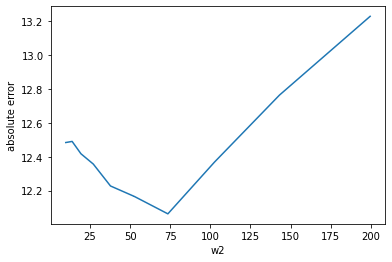

In [27]:
plt.errorbar(w2_list,abe_list,yerr=abe_unc_list)
plt.ylabel("absolute error")
plt.xlabel("w2")
plt.savefig("non_linear_prior_mov_abe_v_w2_{}_to_{}.png".format(log_min, log_max))

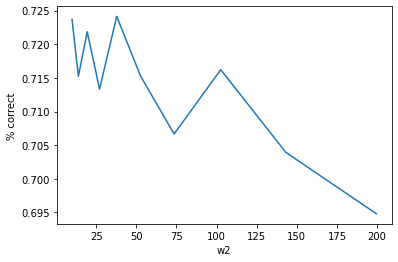

In [28]:
plt.errorbar(w2_list,per_corr_list,yerr=per_corr_unc_list)
plt.ylabel("% correct")
plt.xlabel("w2")
plt.savefig("non_linear_prior_mov_percent_corr_v_w2_{}_to_{}.png".format(log_min, log_max))

In [29]:
def linear_func(x,m,b):
    return m * x + b

In [30]:
spreads,preds,_,_ = zip(*predictions)
x,y = preds,spreads
popt,pcov = curve_fit(linear_func,x,y)
popt, pcov

(array([0.60567186, 6.17108478]),
 array([[ 0.00426033, -0.01391522],
        [-0.01391522,  1.39810632]]))

In [33]:
np.mean(np.abs(np.subtract(x,y)))

13.227272727272727

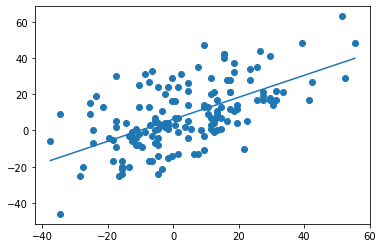

In [31]:
x_space = np.linspace(np.min(x), np.max(x),100)
y_pred = linear_func(x_space,*popt)
plt.scatter(x,y)
plt.plot(x_space,y_pred)